In [7]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sb 


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics 
from sklearn.svm import SVC
from xgboost import XGBClassifier 
from sklearn.linear_model import LogisticRegression



import warnings
warnings.filterwarnings('ignore')

In [8]:
df = pd.read_csv('spaceship_titanic.csv')
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [9]:
df.shape

(8693, 14)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


As per the above information regarding the data in each column we can observe that there are null values in approximately all the columns.

In [11]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000



Data Cleaning

The data which is obtained from the primary sources is termed the raw data and required a lot of preprocessing before we can derive any conclusions from it or do some modeling on it. Those preprocessing steps are known as data cleaning and it includes, outliers removal, null value imputation, and removing discrepancies of any sort in the data inputs.

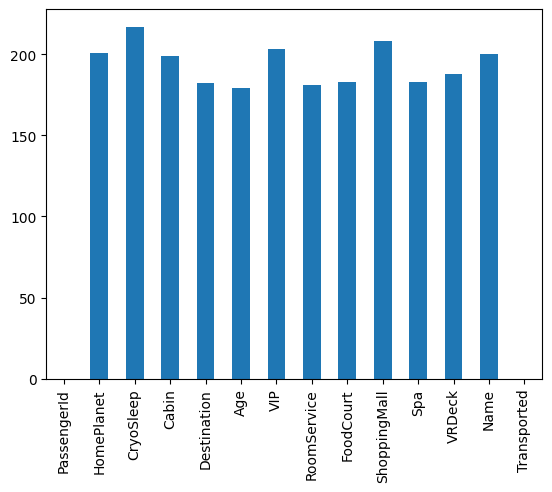

In [12]:
df.isnull().sum().plot.bar()
plt.show()

One of the naive methods to perform the imputation is to simply impute null by mean in the case of continuous data and mode in the case of categorical values but here we will try to explore the relationship between independent features and then we’ll use them to impute the null values smartly.

In [13]:
col = df.loc[:,'RoomService': 'VRDeck'].columns
df.groupby('VIP')[col].mean()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
VIP,,,,,
False,217.218527,426.336536,173.876298,301.711045,282.718056
True,473.615385,1811.393782,247.726804,760.710660,1234.856410


As expected expenditure of VIP people is a little bit on the higher side as compared to those who are non-VIP.

In [16]:
df.groupby('CryoSleep')[col].mean()


,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
CryoSleep,,,,,
False,350.146772,713.004316,270.586504,486.09294,475.716165
True,0.000000,0.000000,0.000000,0.00000,0.000000


Passengers in CryoSleep are confined to their cabins and suspended in the animation during the whole voyage so, they won’t be able to spend on the services available onboard. Hence we can simply put 0 in the case where CryoSleep is equal to True.

In [17]:
temp = df['CryoSleep'] == True
df.loc[temp, col] = 0.0

By using the relation between the VIP people and their expenditure on different leisures let’s impute null values in those columns.

In [18]:
for c in col:
    for val in [True, False]:
        temp = df['VIP']  == val
        # calculate mean only for numeric columns
        k = df.loc[temp,c].astype(float).mean() # Convert to float to ensure numeric calculation
        df.loc[temp, c] = df.loc[temp, c].fillna(k)
        
        # this code is modified by Susobhan AKhuli

Now let’s explore the relationship between the VIP feature and HomePlanet Feature.

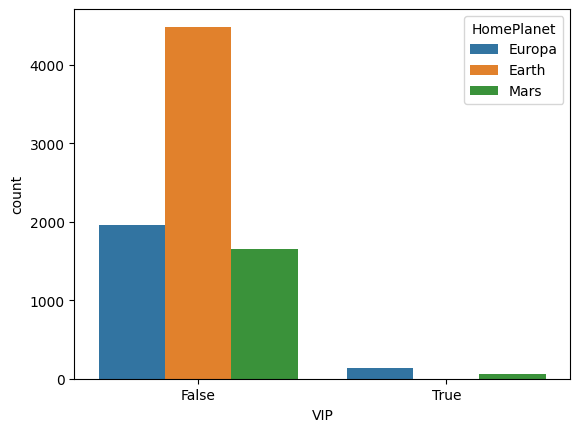

In [19]:
sb.countplot(data=df, x='VIP',
             hue='HomePlanet')
plt.show()

Here we can observe that there is a significant relationship between being a non-VIP and coming from Earth and being a VIP and coming from Europa. The probability of these two events is high.

In [20]:
col = 'HomePlanet'
temp = df['VIP']  == False
df.loc[temp, col] = df.loc[temp, col].fillna('Earth')

temp = df['VIP'] == True
df.loc[temp, col] = df.loc[temp, col].fillna('Europa')

We will simply impute the age null values by mean but before that, we will check for outliers.

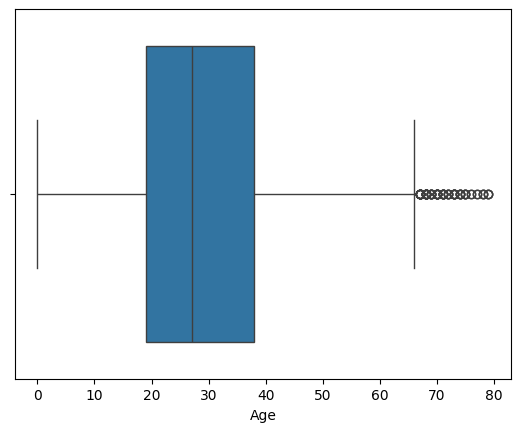

In [21]:
sb.boxplot(df['Age'],orient='h')
plt.show()

We will calculate the mean by excluding outliers and then impute the nulls by that value.

In [23]:
temp = df[df['Age'] < 61]['Age'].mean()
df['Age'] = df['Age'].fillna(temp)


Now let’s explore the relation between CryoSleep and Transported.

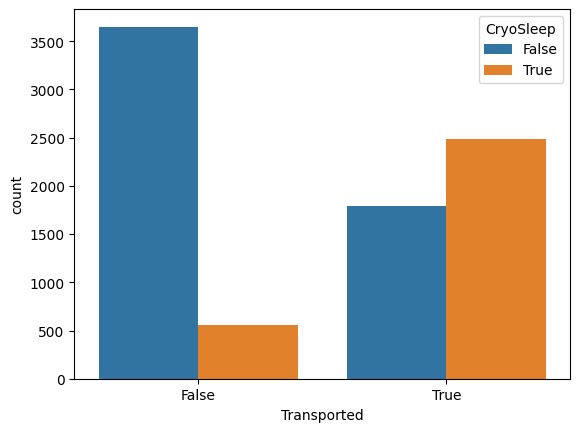

In [24]:
sb.countplot(data=df,
             x='Transported',
             hue='CryoSleep')
plt.show()

Here we can observe that those who are in CryoSLeep have higher chances of getting transported but we cannot use the relation between the target column and independent feature to impute it else we will have to face Data Leakage.

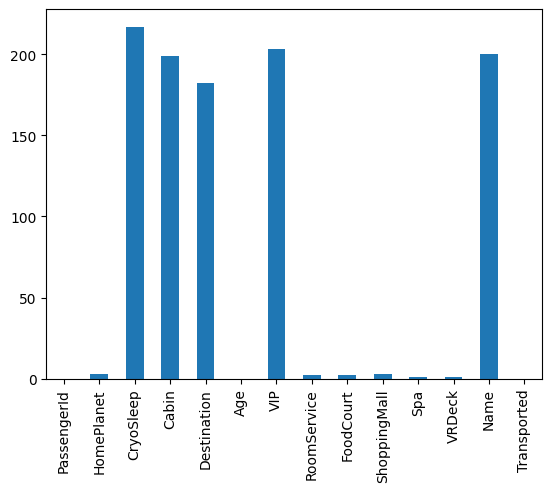

In [25]:
df.isnull().sum().plot.bar()
plt.show()

So, there are still null values in the data. We tried to fill as many null values as possible using the relation between different features. Now let’s fill the remaining values using the Naive method of filling null values that we discussed earlier.

In [26]:
for col in df.columns:
    # Check for null values presence 
    if df[col].isnull().sum()==0:
        continue
    # If the data type is categorical filling by mode.
    if df[col].dtype == object or df[col].dtype == bool:
        df[col] = df[col].fillna(df[col].mode()[0])
        
        # Else by mean
    else:
        df[col] = df[col].fillna(df[col].mean())
        
df.isnull().sum().sum()            

0

Finally, we get rid of the null values from the dataset.

Feature Engineering

There are times when multiple features are provided in the same feature or we have to derive some features from the existing ones. We will also try to include some extra features in our dataset so, that we can derive some interesting insights from the data we have. Also if the features derived are meaningful then they become a deciding factor in increasing the model’s accuracy significantly.

In [27]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Here we can see that PassengerId and Cabin seem to contain some information in the cubbed form. Like in the PassengerId RoomNo_PassengerNo is an expected way to write the clubbed information.

In [28]:
new = df["PassengerId"].str.split("_", n=1, expand=True)
df["RoomNo"] = new[0].astype(int)
df["PassengerNo"] = new[1].astype(int)


df.drop(['PassengerId', 'Name'],
        axis=1, inplace=True)

Now we will fill each room no with the maximum number of passengers it is holding.

In [29]:
data = df['RoomNo']
for i in range(df.shape[0]):
    temp = data == data[i]
    df['PassengerNo'][i] = (temp).sum() # this was throwing an indentation error
    

Now RoomNo does not have any relevance in getting Transported so, we’ll remove it.

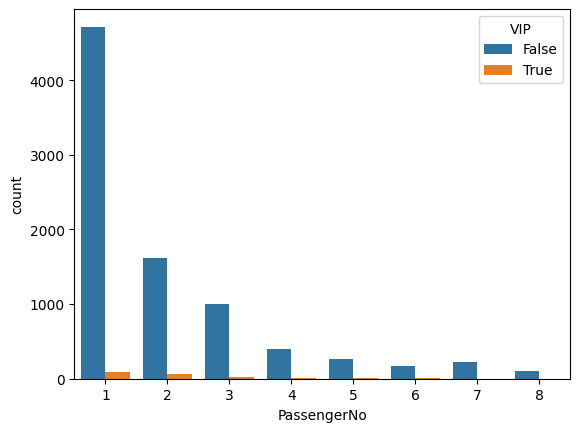

In [30]:
df.drop(['RoomNo'], axis=1,
        inplace=True)
sb.countplot(data=df,
             x= 'PassengerNo',
             hue='VIP')
plt.show()

Here it is clear that VIP people sharing a room is not that common

In [31]:
new = df["Cabin"].str.split("/", n=2, expand=True)
data["F1"] = new[0]
df["F2"] = new[1].astype(int)
df["F3"] = new[2]

df.drop(['Cabin'], axis=1,
        inplace=True)

Now let’s combine all the expenses into one column and name it as

In [33]:
df['LeasureBill'] = df['RoomService'] + df['FoodCourt']\
 + df['ShoppingMall'] + df['Spa'] + df['VRDeck']


Exploratory Data Analysis

EDA is an approach to analyzing the data using visual techniques. It is used to discover trends, and patterns, or to check assumptions with the help of statistical summaries and graphical representations. Although we have explored the relationship between different independent features in the data cleaning part up to a great extent there are some things that are still left.

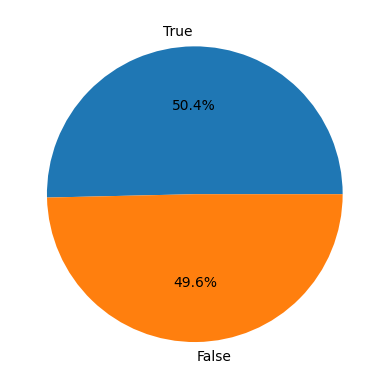

In [35]:
x = df['Transported'].value_counts()
plt.pie(x.values,
        labels=x.index,
        autopct='%1.1f%%')
plt.show()

Data is balanced for both the classes which are good news with respect to the model’s training.

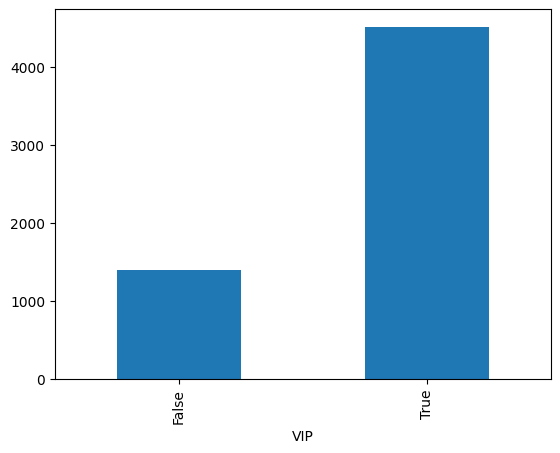

In [37]:
df.groupby('VIP').mean(numeric_only=True)['LeasureBill'].plot.bar() # Add numeric_only=True to handle potential non-numeric columns
plt.show()

# This code is modified by Susobhan Akhuli


High LeasureBill is normal for VIP category people.

In [39]:
for col in df.columns:
      # In case of categorical column 
    # encode them
    if df[col].dtype == object:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

    # In case of boolean data type 
    # convert them to binary
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(int)

df.head()


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerNo,F2,F3,LeasureBill
0,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0.0
1,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,1,1,0,1,736.0
2,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,2,0,1,10383.0
3,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,2,0,1,5176.0
4,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,1,1,1,1,1091.0


Now let’s check the data for the presence of any highly correlated features.

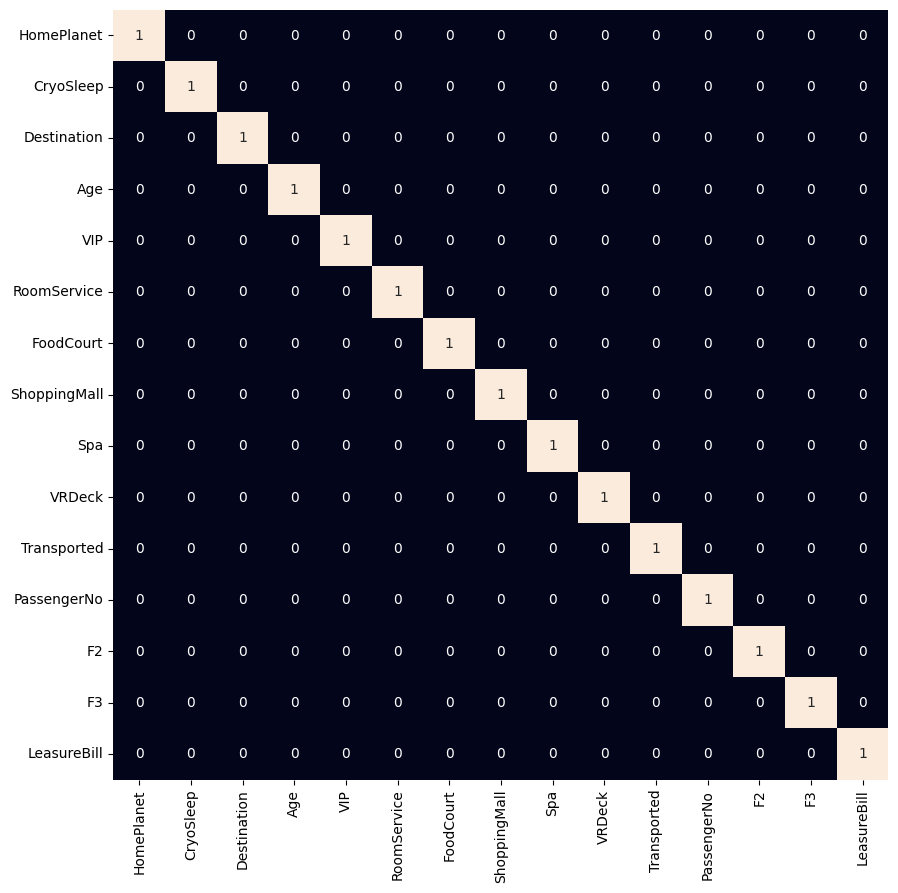

In [40]:
plt.figure(figsize=(10,10))
sb.heatmap(df.corr() >0.8,
           annot=True,
           cbar=False)
plt.show()

From the above heat map, we can see that there are no highly correlated features which implies we are good to go for our model development part.

Model Training

Now we will separate the features and target variables and split them into training and the testing data by using which we will select the model which is performing best on the validation data.

In [42]:
features = df.drop(['Transported'], axis=1)
target = df.Transported

X_train, X_val,\
    Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.1,
                                      random_state=22)

X_train.shape, X_val.shape


((7823, 14), (870, 14))

Now, let’s normalize the data to obtain stable and fast training.

In [43]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

Now let’s train some state-of-the-art machine learning models and compare them which fit better with our data.

In [45]:
from sklearn.metrics import roc_auc_score as ras
models = [LogisticRegression(), XGBClassifier(),
          SVC(kernel='rbf', probability=True)]

for i in range(len(models)):
    models[i].fit(X_train, Y_train)

    print(f'{models[i]} : ')

    train_preds = models[i].predict_proba(X_train)[:, 1]
    print('Training Accuracy : ', ras(Y_train, train_preds))

    val_preds = models[i].predict_proba(X_val)[:, 1]
    print('Validation Accuracy : ', ras(Y_val, val_preds))
    print()


LogisticRegression() : 
Training Accuracy :  0.8690376496826604
Validation Accuracy :  0.8572889727392208

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy :  0.9834723291613665
Validation Accuracy :  0.8761711959977955

SVC(probability=True) : 
Training Accuracy :  0.8

Model Evaluation
From the above accuracies, we can say that XGBClassifier’s performance is the best among all the three models that we have trained. Let’s plot the confusion matrix as well for the validation data using the XGBClassifier model.

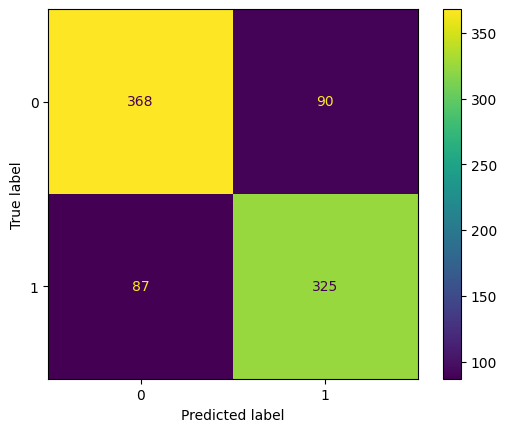

In [47]:
y_pred = models[1].predict(X_val)
cm = metrics.confusion_matrix(Y_val, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


Here from the confusion matrix, we can conclude one thing the model is facing difficulty in predicting negative examples as negative.

In [48]:
print(metrics.classification_report
      (Y_val, models[1].predict(X_val)))

              precision    recall  f1-score   support

           0       0.81      0.80      0.81       458
           1       0.78      0.79      0.79       412

    accuracy                           0.80       870
   macro avg       0.80      0.80      0.80       870
weighted avg       0.80      0.80      0.80       870

